In [2]:
spark

In [40]:
df=spark.read.csv("salarios_profs.csv", header=True, sep=";", encoding="latin1")

In [41]:
df.printSchema()

root
 |-- NOME: string (nullable = true)
 |-- UNID_ORGAO: string (nullable = true)
 |-- DEPTO_SETOR: string (nullable = true)
 |-- JORNADA: string (nullable = true)
 |-- CATEGORIA: string (nullable = true)
 |-- CLASSE: string (nullable = true)
 |-- REF_MS: string (nullable = true)
 |-- FUNCAO: string (nullable = true)
 |-- FUNCAO_ESTRUTURA: string (nullable = true)
 |-- TEMPO_USP: string (nullable = true)
 |-- PARCELAS_EVENTUAIS: string (nullable = true)
 |-- SALARIO_MENSAL: string (nullable = true)
 |-- SALARIO_MENSAL_LIQUIDO: string (nullable = true)



In [42]:
df.limit(5).toPandas()

,NOME,UNID_ORGAO,DEPTO_SETOR,JORNADA,CATEGORIA,CLASSE,REF_MS,FUNCAO,FUNCAO_ESTRUTURA,TEMPO_USP,PARCELAS_EVENTUAIS,SALARIO_MENSAL,SALARIO_MENSAL_LIQUIDO
0,Abel Elias Rahal,PUSP-RP,Seção Técnica de Práticas Esportivas,30 Horas,Celetista,Superior 2,A,Educador Em Praticas Desportivas,None,46,"18432,97","12967,38","17584,07"
1,Abel Lavorenti,ESALQ,Inativo,RDIDP,Doc Apos,Prof Titular,MS-6,Professor Titular,None,0,"27516,8","27516,8","38598,04"
2,Abelardo Cecilio de Souza,FMVZ,Clínica Médica,40 Horas,Celetista,Básico 3,A,Auxiliar de Laboratorio,None,29,"6710,24","6710,24","7317,24"
3,Abib Salim Cury,FORP,Inativo,RTP,Doc Apos,Prof Titular,MS-6,Professor Titular,None,0,"7910,41","7910,41","10064,15"
4,Abidias Lourenco de Alcantara,FCF,Seção de Manutenção e Reparos,40 Horas,Celetista,Básico 2,A,Encanador,None,22,"4567,32","4636,18","5389,03"


In [88]:
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType

def to_value(v):
    try:
        return float(v.replace(",", "."))
    except ValueError:
        return 0.0
udf_to_value = F.udf(to_value, FloatType())

In [107]:
df_typed1 = df.filter(df["DEPTO_SETOR"]!="Inativo")

In [108]:
df_typed = df_typed1.withColumn("Parcelas Eventuais", udf_to_value(df["PARCELAS_EVENTUAIS"])) \
  .withColumn("Salario Mensal", udf_to_value(df["SALARIO_MENSAL"])) \
  .withColumn("Salario Mensal Liquido", udf_to_value(df["SALARIO_MENSAL_LIQUIDO"]))

In [109]:
df_typed.select("NOME", "DEPTO_SETOR", "Parcelas Eventuais").limit(10).toPandas()


,NOME,DEPTO_SETOR,Parcelas Eventuais
0,Abel Elias Rahal,Seção Técnica de Práticas Esportivas,18432.970703
1,Abelardo Cecilio de Souza,Clínica Médica,6710.240234
2,Abidias Lourenco de Alcantara,Seção de Manutenção e Reparos,4567.319824
3,Abigail Barreto de Souza Simphronio,Seção de Almoxarifado,10617.690430
4,Abílio César Neves Tavares,"Diretoria Faculdade de Filosofia, Letras e Ciê...",21552.140625
5,Abinadabe Dornela dos Santos,Seção de Manutenção e Conservação,2966.750000
6,Abiude Ferreira da Silva,Seção de Serviços Gerais,4171.529785
7,Ablicio Pires dos Reis,Física Aplicada,16576.759766
8,Abner Cardoso Rodrigues Neto,Ciência da Computação,782.260010
9,Abner Gosmini,Seção de Finanças e Contabilidade,15042.280273


In [110]:
pd=df_typed.groupBy("DEPTO_SETOR") \
 .agg((F.sum("Salario Mensal Liquido") / F.lit(1_000_000)).alias("Total")) \
 .orderBy("Total", ascending =False) \
 .limit(20).toPandas()
pd

,DEPTO_SETOR,Total
0,Seção Técnica de Informática,3.262731
1,Clínica Médica,2.685327
2,Matemática,2.109974
3,Assistência Técnica Acadêmica,1.681020
4,Letras Clássicas e Vernáculas,1.592070
5,Assistência Técnica Administrativa,1.555768
6,Química Fundamental,1.526288
7,Engenharia Mecânica,1.388944
8,Administração,1.210720
9,"Fisioterapia, Fonoaudiologia e Terapia Ocupaci...",1.180011


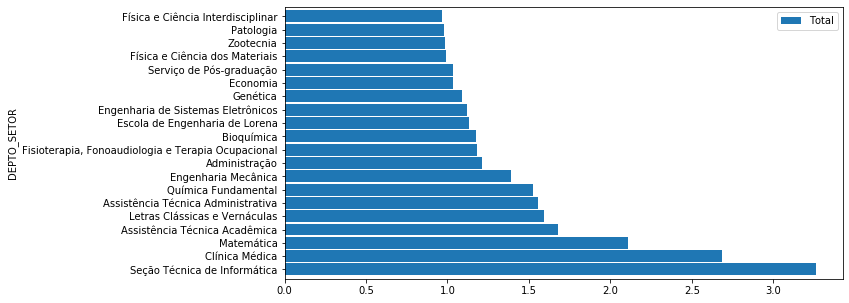

In [111]:
%matplotlib inline
pd.plot(kind="barh", x="DEPTO_SETOR", figsize=[10, 5], width= 0.9)

In [114]:
df_typed.groupBy("FUNCAO") \
 .agg((F.sum("Salario Mensal Liquido") / F.lit(1_000)).alias("SalarioFunção")) \
 .orderBy("SalarioFunção", ascending=False) \
 .limit(10) \
 .toPandas()

,FUNCAO,SalarioFunção
0,Professor Associado,36198.167819
1,Professor Doutor,31375.662365
2,Professor Titular,23857.200793
3,Tec Assuntos Administrativos,13623.306175
4,Técnico de Laboratório,9008.763731
5,Especialista em Laboratório,8582.619315
6,Médico,7247.275664
7,Secretário,6571.250172
8,Auxiliar de Administração,4670.182312
9,Analista de Sistemas,4492.656227
